## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_AtomBlastTwin.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_AtomBlastTwin

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [57]:
import sys
import ast
import numpy as np
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
from asyncroscopy.utils import parula_color_map
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
import pyTEMlib
from pyTEMlib import probe_tools as pt
from scipy.ndimage import gaussian_filter
from skimage.feature import blob_log
from pyTEMlib.atom_tools import atom_refine

%matplotlib ipympl

### Connections:

In [58]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003),
                "Preacquired_AS": ("localhost", 9004)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000
# then kill PIDs on that port


Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [59]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'localhost','port':9001})
tem.send_command(destination = 'Ceos', command = 'getInfo', args = {})

'CEOS Digital Twin Server'

### Help commands:

In [60]:
# Now that we're routed to all instruments,
# let's take an inventory of commands available on each instrument
cmds = tem.send_command('AS', 'discover_commands')
print(cmds)

["blank_beam", "connect_AS", "connectionLost", "connectionMade", "dataReceived", "disconnect", "discover_commands", "get_atom_count", "get_dose_map", "get_help", "get_scanned_image", "get_stage", "get_status", "lengthLimitExceeded", "load_sample", "logPrefix", "makeConnection", "pauseProducing", "place_beam", "reset_sample", "resumeProducing", "sendString", "set_beam_current", "set_fov", "stopProducing", "stringReceived", "unblank_beam"]


### Setting the aberrations from known values:

In [61]:
aberrations = pt.get_target_aberrations("Spectra300", 200000)
aberrations['C23a'] = 10
aberrations['C23b'] = 10
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)
pt.print_aberrations(aberrations)

In [62]:
tem.send_command('AS', 'load_sample') #change


'Loaded sample with 3600 atoms. Dose map initialized.'

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

'Current atom count: 3600'

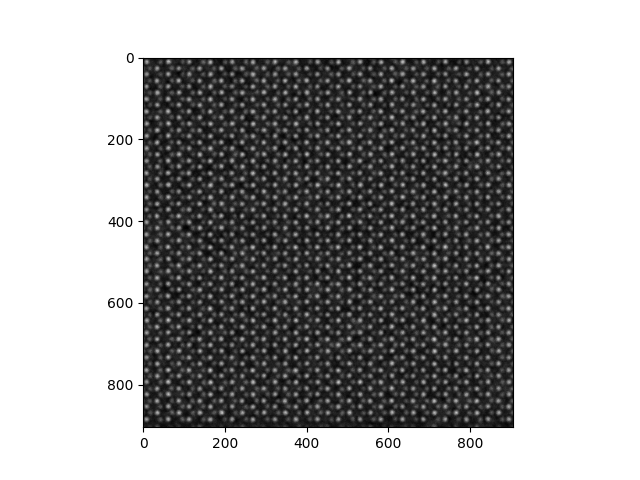

In [63]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img, cmap="gray")
tem.send_command('AS', 'get_atom_count', {})

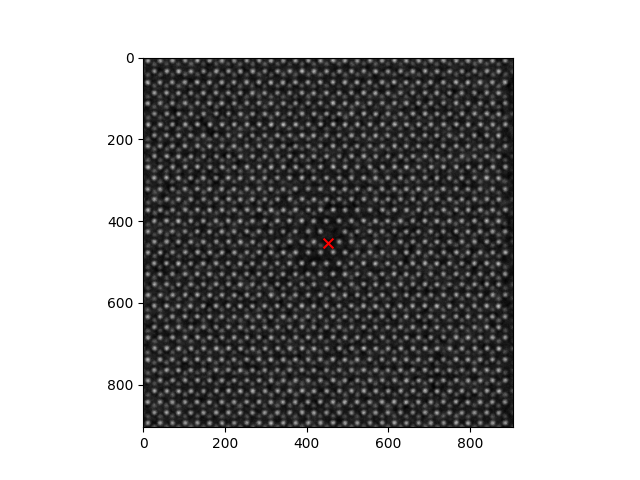

In [64]:
# Position beam and expose
beam_pos = [0.5, 0.5] # move beam around 

beam_current = 1000000 # change beam current for hole drilling
tem.send_command('AS', 'place_beam', {'x': beam_pos[1], 'y': beam_pos[0]})
tem.send_command('AS', 'set_beam_current', {'current': beam_current})
tem.send_command('AS', 'unblank_beam', {'duration': 1}) # seconds

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
plt.scatter(beam_pos[1] * img.shape[1], beam_pos[0] * img.shape[0], color='red', s=50, marker='x')


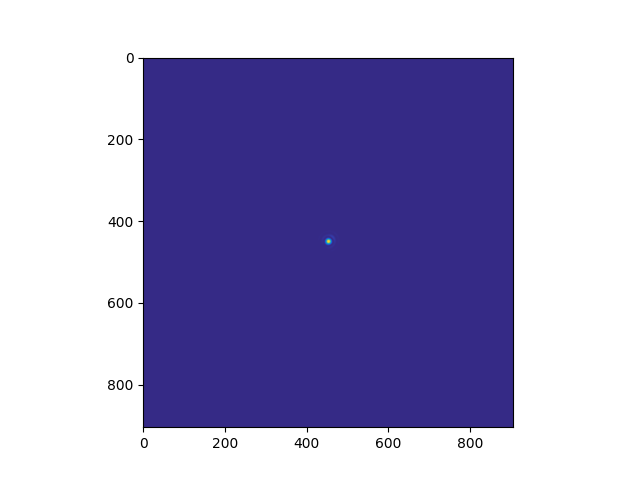

In [65]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)

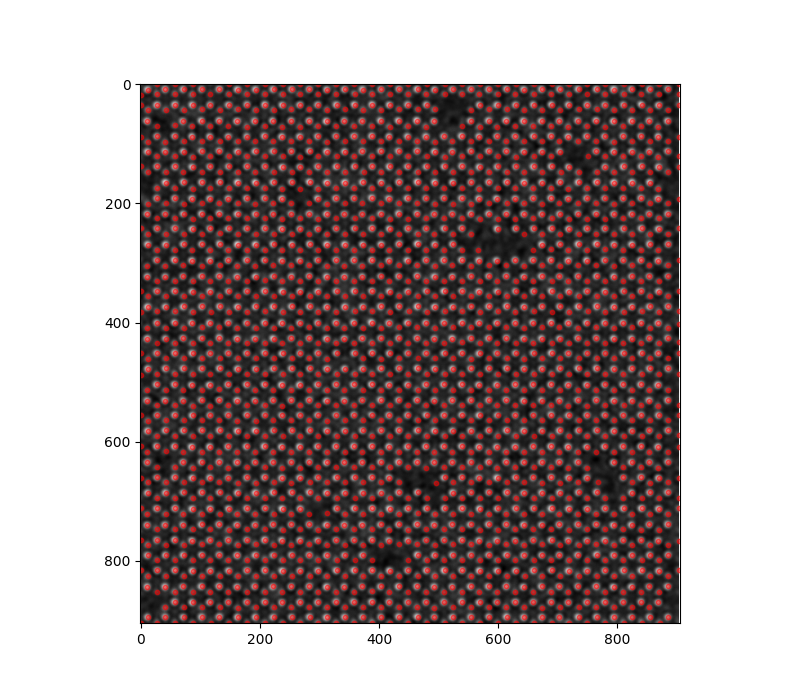

In [68]:
blurred = gaussian_filter(img, sigma=1)
blobs = blob_log(blurred, max_sigma=3, threshold=0.05)

fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
ax.scatter(blobs[:, 0], blobs[:, 1], c='r', s=10, alpha = .5)
atom_radius = 3 
sym = atom_refine(img, blobs, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])
intensities = np.array(sym['intensity_area'])

to_delete = np.where(intensities < 0)
refined_atoms = np.delete(refined_atoms, to_delete, axis=0)
intensities = np.delete(intensities, to_delete, axis=0)

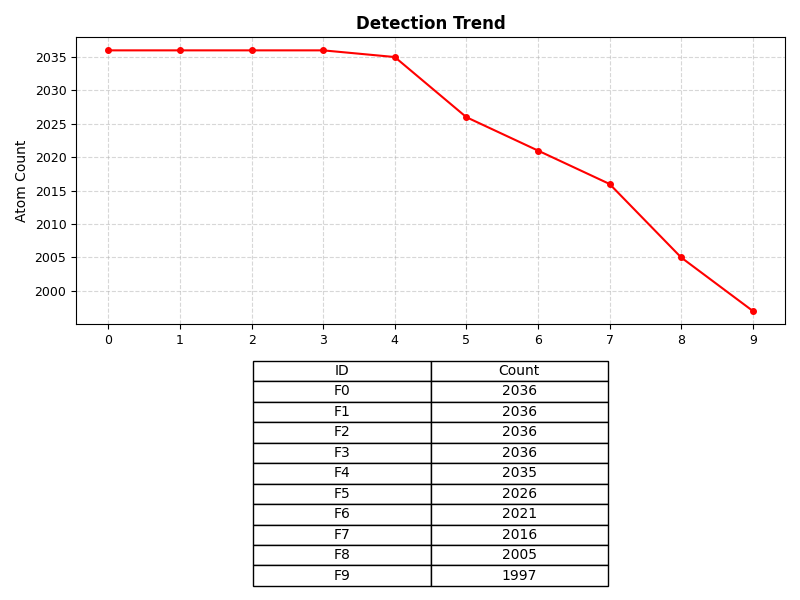

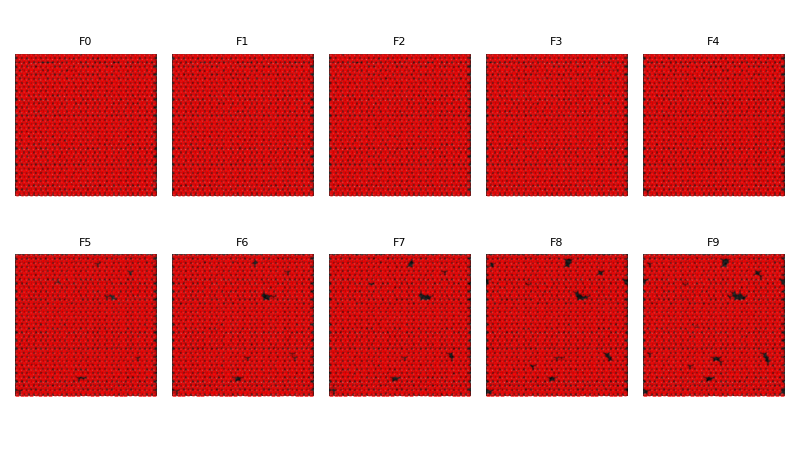

In [66]:
tem.send_command('AS', 'load_sample') #comment out if you want to keep shooting electrons at the sample
#otherwise leave to get new samples

n_frames = 10
beam_current = 50 # imaging current
tem.send_command('AS', 'set_beam_current', {'current': beam_current}) 

fig_imgs, ax_imgs = plt.subplots(2, 5, figsize=(8, 4.5)) 
ax_imgs = ax_imgs.ravel()

blob_count = [] 

for frame in range(n_frames):
    img = tem.send_command('AS', 'get_scanned_image', image_args)
    blurred = gaussian_filter(img, sigma=1)
    blobs = blob_log(blurred, max_sigma=3, threshold=0.05)
    atom_radius = 3  
    sym = atom_refine(img, blobs, atom_radius, max_int=0, min_int=0, max_dist=2)
    refined_atoms = np.array(sym['atoms'])
    intensities = np.array(sym['intensity_area'])

    to_delete = np.where(intensities < 0)
    refined_atoms = np.delete(refined_atoms, to_delete, axis=0)
    
    blob_count.append(len(refined_atoms))
    ax_imgs[frame].imshow(img.T, cmap='gray')
    ax_imgs[frame].scatter(refined_atoms[:, 0], refined_atoms[:, 1], c='r', s=5, alpha=0.5) 
    ax_imgs[frame].set_title(f"F{frame}", fontsize=8) 
    ax_imgs[frame].axis('off')

fig_imgs.tight_layout()
fig_analysis, (ax_graph, ax_table) = plt.subplots(2, 1, figsize=(8, 6), 
                                                gridspec_kw={'height_ratios': [2, 1]})

ax_graph.plot(range(n_frames), blob_count, marker='o', color='red', linewidth=1.5, markersize=4)
ax_graph.set_ylabel('Atom Count', fontsize=10)
ax_graph.set_title('Detection Trend', fontsize=12, fontweight='bold')
ax_graph.set_xticks(range(n_frames))
ax_graph.tick_params(labelsize=9)
ax_graph.grid(True, linestyle='--', alpha=0.5)

ax_table.axis('off')
table_data = [[f"F{i}", count] for i, count in enumerate(blob_count)]
table = ax_table.table(
    cellText=table_data, 
    colLabels=['ID', 'Count'], 
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.5, 1.2)

plt.tight_layout()
plt.show()